# **Модуль Б**. Разработка модели машинного обучения

## Импортирование библиотек

In [210]:
# модули для работы с моделью
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

import pandas as pd

from IPython.display import Audio

from Model.tokenizer import Tokenizer

import numpy as np

from IPython.display import Audio

import librosa
import librosa.display
import matplotlib.pyplot as plt

import math

from tqdm import tqdm  # Импортируем tqdm



## Загрузка данных

In [194]:
# путь к обработанным данным
df_path = '../Module1/Dataset/dataset.h5'
# загружаем датасета
df = pd.read_hdf(df_path, key='df')
df.head()

,token_ids,mel_spec
0,"[3, 15, 3, 26, 1, 15, 23, 32, 1, 4, 8, 1, 31, ...","[[-13.800305818143135, -11.439843118946193, -8..."
1,"[5, 17, 15, 12, 3, 19, 1, 12, 18, 7, 12, 3, 1,...","[[-13.808701526509054, -12.847779898242456, -1..."
2,"[13, 22, 8, 32, 3, 31, 6, 1, 4, 29, 0, 4, 18, ...","[[-13.813741254347589, -11.622957041259623, -7..."
3,"[10, 31, 17, 1, 4, 18, 31, 23, 1, 13, 32, 17, ...","[[-13.814922695056433, -12.708897850124652, -9..."
4,"[12, 27, 3, 22, 28, 3, 31, 1, 5, 17, 9, 18, 31...","[[-13.815510557964274, -13.815510557964274, -1..."


In [195]:
text_token_example = df['token_ids'][42]

print(text_token_example)

[8, 27, 28, 18, 9, 8, 26, 13, 12, 17, 26, 1, 13, 18, 25, 16, 1, 15, 29, 22, 8, 31, 1, 18, 13, 31, 3, 27, 3, 31, 6, 13, 19, 1, 4, 3, 15, 32, 25, 22, 3, 31, 8, 32, 8, 24, 1, 27, 1, 5, 8, 4, 8, 28, 3, 32, 6, 4, 18, 26, 1, 3, 13, 13, 3, 24, 15, 32, 8, 8, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34]


**Класс с моделью**

In [196]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class TTSTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_mels=80, time_steps=498, pad_token_id=34):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_token_id)
        self.pos_encoder = PositionalEncoding(d_model)

        self.prenet = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead=4, dropout=0.1, batch_first=True),
            num_layers=3
        )

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=4, batch_first=True)

        self.decoder = nn.Sequential(
            nn.Linear(d_model, d_model * 2),  # для GLU
            nn.GLU(),                         # половина каналов остаётся
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_mels)        # (batch, seq_len, n_mels)
        )

        self.n_mels = n_mels
        self.time_steps = time_steps

    def forward(self, tokens):
        mask = (tokens == self.embedding.padding_idx)  # (batch, seq_len)

        x = self.embedding(tokens)                     # (batch, seq_len, d_model)
        x = self.pos_encoder(x)                        # +позиции
        x = self.prenet(x)                             # PreNet
        x = self.encoder(x, src_key_padding_mask=mask) # Transformer

        # x, _ = self.attn(x, x, x, key_padding_mask=mask)  # Self-Attention

        x = self.decoder(x)                            # (batch, seq_len, n_mels)

        x = x.permute(0, 2, 1)                         # → (batch, n_mels, seq_len)
        x = F.interpolate(x, size=self.time_steps, mode="linear", align_corners=True)
        x = x.permute(0, 2, 1)                         # → (batch, time_steps, n_mels)

        return x

In [197]:
class TTSDataset(Dataset):
    def __init__(self, tokenized_texts, mel_spectrograms):
        self.tokenized_texts = tokenized_texts
        self.mel_spectrograms = mel_spectrograms
        
        self.n_mels = mel_spectrograms[0].shape[1]

    def __len__(self):
        return len(self.tokenized_texts)

    def __getitem__(self, idx):
        return (
            torch.LongTensor(self.tokenized_texts[idx]),
            torch.FloatTensor(self.mel_spectrograms[idx])
        )

In [198]:
tokenized_texts = df['token_ids']
mel_spectrograms = df['mel_spec']


In [199]:
# Создаем DataLoader
dataset = TTSDataset(tokenized_texts, mel_spectrograms)
dataloader = DataLoader(dataset, batch_size=8)

In [200]:
print(dataset.__getitem__(0)[0])
print(dataset.__getitem__(0)[0].shape)
print(dataset.__getitem__(0)[1])
print(dataset.__getitem__(0)[1].shape)

tensor([ 3, 15,  3, 26,  1, 15, 23, 32,  1,  4,  8,  1, 31, 18, 32,  6, 12, 18,
         1, 31,  3, 32,  3,  4, 31, 32, 17, 27, 23, 24,  1,  9, 18, 10, 31, 18,
        24,  1,  4, 18,  1, 17,  1, 29,  2,  8,  4, 23, 24, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34])
torch.Size([99])
tensor([[-1.3800e+01, -1.1440e+01, -8.0100e+00,  ..., -1.3816e+01,
         -2.1925e+00, -9.0196e-03],
        [-1.3787e+01, -1.1711e+01, -7.4625e+00,  ..., -1.3816e+01,
         -3.0342e+00, -7.4582e-01],
        [-1.3810e+01, -1.2327e+01, -9.0296e+00,  ..., -1.3816e+01,
         -3.5755e+00, -1.3221e+00],
        ...,
        [-1.3814e+01, -1.3754e+01, -1.2975e+01,  ..., -1.3816e+01,
         -1.0478e+01, -8.2446e+00],
        [-1.3814e+01, -1.3696e+01, -1.2666e+01,  ..., -1.3816e+01,
         -1.0493e+01, -8.2603e+00],
        [-

In [201]:
# Проверяем один пример
tokens, mel = dataset[0]
print("Пример 0:")
print(f"Токены: {tokens} (длина: {len(tokens)})")
print(f"Спектрограмма: {mel.shape}")

Пример 0:
Токены: tensor([ 3, 15,  3, 26,  1, 15, 23, 32,  1,  4,  8,  1, 31, 18, 32,  6, 12, 18,
         1, 31,  3, 32,  3,  4, 31, 32, 17, 27, 23, 24,  1,  9, 18, 10, 31, 18,
        24,  1,  4, 18,  1, 17,  1, 29,  2,  8,  4, 23, 24, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34]) (длина: 99)
Спектрограмма: torch.Size([80, 498])


In [202]:
# Проверяем батч
for batch_idx, (tokens_batch, mels_batch) in enumerate(dataloader):
    print(f"\nБатч {batch_idx}:")
    print(f"Токены: {tokens_batch.shape}")
    print(f"Спектрограммы: {mels_batch.shape}")
    break


Батч 0:
Токены: torch.Size([8, 99])
Спектрограммы: torch.Size([8, 80, 498])


In [203]:
tokenizer = Tokenizer()

d:\Helper\MLBazyak\chemp\Speech-synthesis\Module2


In [204]:
print(f"Размер словаря: {len(tokenizer.text_to_ids_voc)}")

Размер словаря: 35


In [205]:
import torch.optim as optim

# Параметры
vocab_size = 35  # размер словаря
n_mels = 80
time_steps = 498

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [206]:
# Создание модели
model = TTSTransformer(vocab_size=vocab_size, 
                       d_model=256, 
                       n_mels=n_mels,
                       time_steps=time_steps
                       )
model.to(device)

TTSTransformer(
  (embedding): Embedding(35, 256, padding_idx=34)
  (pos_encoder): PositionalEncoding()
  (prenet): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=Fa

In [207]:
# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [208]:
# Функция потерь (MSE, так как предсказываем спектрограммы)
criterion = nn.MSELoss()

In [209]:
torch.cuda.empty_cache()

In [211]:
from time import time

In [215]:
start = time()
num_epochs = 100  # Количество эпох
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # Прогресс-бар для всех батчей в эпохе
    with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for batch_idx, (texts, mels) in enumerate(pbar):
            texts, mels = texts.to(device), mels.to(device)

            optimizer.zero_grad()

            # Прогон через модель
            pred_mels = model(texts)  # Выход (batch, time_steps, n_mels)
            
            # Транспонируем для корректного сопоставления размерностей
            pred_mels = pred_mels.permute(0, 2, 1)  # (batch, n_mels, time_steps)

            # Подгоняем длину
            min_len = min(pred_mels.shape[2], mels.shape[2])
            pred_mels = pred_mels[:, :, :min_len]
            mels = mels[:, :, :min_len]

            # Функция потерь (например, MSE)
            loss = criterion(pred_mels, mels)
            loss.backward()

            optimizer.step()
            total_loss += loss.item()
            # print(total_loss)
            # print(len(dataloader))

            # Обновляем описание прогресс-бара
            pbar.set_postfix(loss=loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_loss / len(dataloader):.4f}")
print('------------------------------------------------------')
print(f'Время обучения: {(time() - start):.2f}')


Epoch 1/100: 100%|██████████| 293/293 [03:23<00:00,  1.44batch/s, loss=96.1]


Epoch [1/100], Average Loss: 100.1553


Epoch 2/100: 100%|██████████| 293/293 [03:00<00:00,  1.63batch/s, loss=84]  


Epoch [2/100], Average Loss: 86.2152


Epoch 3/100: 100%|██████████| 293/293 [03:15<00:00,  1.50batch/s, loss=73]  


Epoch [3/100], Average Loss: 74.7906


Epoch 4/100: 100%|██████████| 293/293 [03:08<00:00,  1.56batch/s, loss=63.5]


Epoch [4/100], Average Loss: 64.6283


Epoch 5/100: 100%|██████████| 293/293 [02:42<00:00,  1.80batch/s, loss=55.3]


Epoch [5/100], Average Loss: 55.8622


Epoch 6/100: 100%|██████████| 293/293 [02:47<00:00,  1.75batch/s, loss=48.4]


Epoch [6/100], Average Loss: 48.4203


Epoch 7/100: 100%|██████████| 293/293 [02:41<00:00,  1.81batch/s, loss=42.6]


Epoch [7/100], Average Loss: 42.1952


Epoch 8/100: 100%|██████████| 293/293 [02:41<00:00,  1.81batch/s, loss=37.6]


Epoch [8/100], Average Loss: 37.0276


Epoch 9/100: 100%|██████████| 293/293 [02:42<00:00,  1.80batch/s, loss=31.5]


Epoch [9/100], Average Loss: 32.3941


Epoch 10/100: 100%|██████████| 293/293 [02:42<00:00,  1.81batch/s, loss=26.7]


Epoch [10/100], Average Loss: 28.1317


Epoch 11/100: 100%|██████████| 293/293 [02:46<00:00,  1.76batch/s, loss=23]  


Epoch [11/100], Average Loss: 24.5305


Epoch 12/100: 100%|██████████| 293/293 [02:46<00:00,  1.76batch/s, loss=19.1]


Epoch [12/100], Average Loss: 21.4847


Epoch 13/100: 100%|██████████| 293/293 [02:42<00:00,  1.80batch/s, loss=16.2]


Epoch [13/100], Average Loss: 18.9293


Epoch 14/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=13.1]


Epoch [14/100], Average Loss: 16.8079


Epoch 15/100: 100%|██████████| 293/293 [02:47<00:00,  1.75batch/s, loss=11.1]


Epoch [15/100], Average Loss: 15.1022


Epoch 16/100: 100%|██████████| 293/293 [02:46<00:00,  1.76batch/s, loss=9.46]


Epoch [16/100], Average Loss: 13.7392


Epoch 17/100: 100%|██████████| 293/293 [02:36<00:00,  1.88batch/s, loss=8.11]


Epoch [17/100], Average Loss: 12.6857


Epoch 18/100: 100%|██████████| 293/293 [02:59<00:00,  1.63batch/s, loss=7.14]


Epoch [18/100], Average Loss: 11.8845


Epoch 19/100: 100%|██████████| 293/293 [02:47<00:00,  1.75batch/s, loss=6.37]


Epoch [19/100], Average Loss: 11.2905


Epoch 20/100: 100%|██████████| 293/293 [02:46<00:00,  1.76batch/s, loss=5.94]


Epoch [20/100], Average Loss: 10.8749


Epoch 21/100: 100%|██████████| 293/293 [02:43<00:00,  1.79batch/s, loss=5.14]


Epoch [21/100], Average Loss: 10.5612


Epoch 22/100: 100%|██████████| 293/293 [02:39<00:00,  1.83batch/s, loss=5.04]


Epoch [22/100], Average Loss: 10.3714


Epoch 23/100: 100%|██████████| 293/293 [02:44<00:00,  1.78batch/s, loss=5.14]


Epoch [23/100], Average Loss: 10.2339


Epoch 24/100: 100%|██████████| 293/293 [02:46<00:00,  1.76batch/s, loss=4.83]


Epoch [24/100], Average Loss: 10.1590


Epoch 25/100: 100%|██████████| 293/293 [02:51<00:00,  1.71batch/s, loss=4.81]


Epoch [25/100], Average Loss: 10.0890


Epoch 26/100: 100%|██████████| 293/293 [02:44<00:00,  1.79batch/s, loss=4.69]


Epoch [26/100], Average Loss: 10.0462


Epoch 27/100: 100%|██████████| 293/293 [02:41<00:00,  1.82batch/s, loss=4.77]


Epoch [27/100], Average Loss: 10.0154


Epoch 28/100: 100%|██████████| 293/293 [02:44<00:00,  1.78batch/s, loss=4.73]


Epoch [28/100], Average Loss: 9.9850


Epoch 29/100: 100%|██████████| 293/293 [02:41<00:00,  1.82batch/s, loss=5.07]


Epoch [29/100], Average Loss: 9.9676


Epoch 30/100: 100%|██████████| 293/293 [02:41<00:00,  1.82batch/s, loss=4.57]


Epoch [30/100], Average Loss: 9.9306


Epoch 31/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=4.67]


Epoch [31/100], Average Loss: 9.9208


Epoch 32/100: 100%|██████████| 293/293 [02:48<00:00,  1.74batch/s, loss=4.55]


Epoch [32/100], Average Loss: 9.8932


Epoch 33/100: 100%|██████████| 293/293 [02:44<00:00,  1.78batch/s, loss=4.87]


Epoch [33/100], Average Loss: 9.8632


Epoch 34/100: 100%|██████████| 293/293 [02:43<00:00,  1.79batch/s, loss=4.91]


Epoch [34/100], Average Loss: 9.8493


Epoch 35/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=4.77]


Epoch [35/100], Average Loss: 9.8320


Epoch 36/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=5.26]


Epoch [36/100], Average Loss: 9.8190


Epoch 37/100: 100%|██████████| 293/293 [02:44<00:00,  1.78batch/s, loss=4.84]


Epoch [37/100], Average Loss: 9.7899


Epoch 38/100: 100%|██████████| 293/293 [02:50<00:00,  1.72batch/s, loss=5.29]


Epoch [38/100], Average Loss: 9.7774


Epoch 39/100: 100%|██████████| 293/293 [03:31<00:00,  1.39batch/s, loss=5]   


Epoch [39/100], Average Loss: 9.7597


Epoch 40/100: 100%|██████████| 293/293 [03:33<00:00,  1.38batch/s, loss=5.13]


Epoch [40/100], Average Loss: 9.7429


Epoch 41/100: 100%|██████████| 293/293 [02:43<00:00,  1.79batch/s, loss=4.88]


Epoch [41/100], Average Loss: 9.7403


Epoch 42/100: 100%|██████████| 293/293 [02:44<00:00,  1.78batch/s, loss=5.15]


Epoch [42/100], Average Loss: 9.7126


Epoch 43/100: 100%|██████████| 293/293 [02:44<00:00,  1.78batch/s, loss=5.15]


Epoch [43/100], Average Loss: 9.6932


Epoch 44/100: 100%|██████████| 293/293 [02:41<00:00,  1.82batch/s, loss=5.06]


Epoch [44/100], Average Loss: 9.6874


Epoch 45/100: 100%|██████████| 293/293 [02:42<00:00,  1.81batch/s, loss=5.06]


Epoch [45/100], Average Loss: 9.6737


Epoch 46/100: 100%|██████████| 293/293 [02:41<00:00,  1.82batch/s, loss=5.02]


Epoch [46/100], Average Loss: 9.6659


Epoch 47/100: 100%|██████████| 293/293 [02:44<00:00,  1.78batch/s, loss=5]   


Epoch [47/100], Average Loss: 9.6445


Epoch 48/100: 100%|██████████| 293/293 [03:18<00:00,  1.47batch/s, loss=5.07]


Epoch [48/100], Average Loss: 9.6368


Epoch 49/100: 100%|██████████| 293/293 [02:59<00:00,  1.63batch/s, loss=5.24]


Epoch [49/100], Average Loss: 9.6116


Epoch 50/100: 100%|██████████| 293/293 [02:49<00:00,  1.73batch/s, loss=5.45]


Epoch [50/100], Average Loss: 9.6057


Epoch 51/100: 100%|██████████| 293/293 [02:42<00:00,  1.80batch/s, loss=5.19]


Epoch [51/100], Average Loss: 9.6002


Epoch 52/100: 100%|██████████| 293/293 [02:38<00:00,  1.84batch/s, loss=5.67]


Epoch [52/100], Average Loss: 9.5890


Epoch 53/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=5.4] 


Epoch [53/100], Average Loss: 9.5663


Epoch 54/100: 100%|██████████| 293/293 [02:43<00:00,  1.79batch/s, loss=5.48]


Epoch [54/100], Average Loss: 9.5622


Epoch 55/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=5.26]


Epoch [55/100], Average Loss: 9.5463


Epoch 56/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=4.99]


Epoch [56/100], Average Loss: 9.5311


Epoch 57/100: 100%|██████████| 293/293 [02:43<00:00,  1.79batch/s, loss=4.85]


Epoch [57/100], Average Loss: 9.5203


Epoch 58/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=5.21]


Epoch [58/100], Average Loss: 9.5122


Epoch 59/100: 100%|██████████| 293/293 [02:48<00:00,  1.74batch/s, loss=5.28]


Epoch [59/100], Average Loss: 9.5112


Epoch 60/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=5.85]


Epoch [60/100], Average Loss: 9.4864


Epoch 61/100: 100%|██████████| 293/293 [02:46<00:00,  1.76batch/s, loss=4.92]


Epoch [61/100], Average Loss: 9.4826


Epoch 62/100: 100%|██████████| 293/293 [02:43<00:00,  1.79batch/s, loss=5.05]


Epoch [62/100], Average Loss: 9.4820


Epoch 63/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=5.17]


Epoch [63/100], Average Loss: 9.4613


Epoch 64/100: 100%|██████████| 293/293 [02:46<00:00,  1.76batch/s, loss=5.29]


Epoch [64/100], Average Loss: 9.4573


Epoch 65/100: 100%|██████████| 293/293 [02:48<00:00,  1.74batch/s, loss=5.2] 


Epoch [65/100], Average Loss: 9.4477


Epoch 66/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=5.69]


Epoch [66/100], Average Loss: 9.4465


Epoch 67/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=5.55]


Epoch [67/100], Average Loss: 9.4359


Epoch 68/100: 100%|██████████| 293/293 [02:49<00:00,  1.73batch/s, loss=5.14]


Epoch [68/100], Average Loss: 9.4345


Epoch 69/100: 100%|██████████| 293/293 [02:43<00:00,  1.80batch/s, loss=5.53]


Epoch [69/100], Average Loss: 9.4272


Epoch 70/100: 100%|██████████| 293/293 [02:46<00:00,  1.76batch/s, loss=5.3] 


Epoch [70/100], Average Loss: 9.4187


Epoch 71/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=5.24]


Epoch [71/100], Average Loss: 9.4159


Epoch 72/100: 100%|██████████| 293/293 [02:46<00:00,  1.76batch/s, loss=5.07]


Epoch [72/100], Average Loss: 9.4199


Epoch 73/100: 100%|██████████| 293/293 [02:50<00:00,  1.72batch/s, loss=5.38]


Epoch [73/100], Average Loss: 9.4035


Epoch 74/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=5.38]


Epoch [74/100], Average Loss: 9.4090


Epoch 75/100: 100%|██████████| 293/293 [02:46<00:00,  1.76batch/s, loss=5.44]


Epoch [75/100], Average Loss: 9.3909


Epoch 76/100: 100%|██████████| 293/293 [02:43<00:00,  1.80batch/s, loss=5.16]


Epoch [76/100], Average Loss: 9.3861


Epoch 77/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=5.15]


Epoch [77/100], Average Loss: 9.3761


Epoch 78/100: 100%|██████████| 293/293 [02:47<00:00,  1.75batch/s, loss=5.33]


Epoch [78/100], Average Loss: 9.3898


Epoch 79/100: 100%|██████████| 293/293 [02:44<00:00,  1.79batch/s, loss=5.4] 


Epoch [79/100], Average Loss: 9.3797


Epoch 80/100: 100%|██████████| 293/293 [02:44<00:00,  1.78batch/s, loss=5.19]


Epoch [80/100], Average Loss: 9.3794


Epoch 81/100: 100%|██████████| 293/293 [02:46<00:00,  1.76batch/s, loss=5.48]


Epoch [81/100], Average Loss: 9.3808


Epoch 82/100: 100%|██████████| 293/293 [02:47<00:00,  1.75batch/s, loss=5.32]


Epoch [82/100], Average Loss: 9.3680


Epoch 83/100: 100%|██████████| 293/293 [02:48<00:00,  1.74batch/s, loss=5.43]


Epoch [83/100], Average Loss: 9.3680


Epoch 84/100: 100%|██████████| 293/293 [02:41<00:00,  1.81batch/s, loss=5.32]


Epoch [84/100], Average Loss: 9.3646


Epoch 85/100: 100%|██████████| 293/293 [02:46<00:00,  1.76batch/s, loss=5.44]


Epoch [85/100], Average Loss: 9.3548


Epoch 86/100: 100%|██████████| 293/293 [02:48<00:00,  1.74batch/s, loss=5.57]


Epoch [86/100], Average Loss: 9.3647


Epoch 87/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=5.48]


Epoch [87/100], Average Loss: 9.3461


Epoch 88/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=5.77]


Epoch [88/100], Average Loss: 9.3514


Epoch 89/100: 100%|██████████| 293/293 [02:42<00:00,  1.80batch/s, loss=5.56]


Epoch [89/100], Average Loss: 9.3434


Epoch 90/100: 100%|██████████| 293/293 [02:49<00:00,  1.73batch/s, loss=5.27]


Epoch [90/100], Average Loss: 9.3527


Epoch 91/100: 100%|██████████| 293/293 [02:49<00:00,  1.73batch/s, loss=5.54]


Epoch [91/100], Average Loss: 9.3413


Epoch 92/100: 100%|██████████| 293/293 [02:47<00:00,  1.75batch/s, loss=5.47]


Epoch [92/100], Average Loss: 9.3487


Epoch 93/100: 100%|██████████| 293/293 [02:45<00:00,  1.77batch/s, loss=5.18]


Epoch [93/100], Average Loss: 9.3423


Epoch 94/100: 100%|██████████| 293/293 [02:47<00:00,  1.75batch/s, loss=5.51]


Epoch [94/100], Average Loss: 9.3400


Epoch 95/100: 100%|██████████| 293/293 [02:48<00:00,  1.74batch/s, loss=5.78]


Epoch [95/100], Average Loss: 9.3401


Epoch 96/100: 100%|██████████| 293/293 [02:47<00:00,  1.75batch/s, loss=5.66]


Epoch [96/100], Average Loss: 9.3342


Epoch 97/100: 100%|██████████| 293/293 [02:46<00:00,  1.76batch/s, loss=5.43]


Epoch [97/100], Average Loss: 9.3247


Epoch 98/100: 100%|██████████| 293/293 [02:48<00:00,  1.74batch/s, loss=5.45]


Epoch [98/100], Average Loss: 9.3343


Epoch 99/100: 100%|██████████| 293/293 [02:47<00:00,  1.75batch/s, loss=5.55]


Epoch [99/100], Average Loss: 9.3122


Epoch 100/100: 100%|██████████| 293/293 [02:50<00:00,  1.72batch/s, loss=5.61]

Epoch [100/100], Average Loss: 9.3247
------------------------------------------------------
Время обучения: 16795.50


In [216]:
def mel_to_audio(mel_spec, sr=16000, n_fft=1024, hop_length=256, n_mels=80):
    # 1. Отмена логарифмирования
    stft = librosa.feature.inverse.mel_to_stft(
        np.exp(mel_spec) - 1e-6,
        sr=sr,
        n_fft=n_fft,
        fmin=50,
        fmax=8000
    )
    
    audio = librosa.griffinlim(
        stft,
        n_iter=100,
        hop_length=hop_length,
        win_length=n_fft
    )
    
    # 3. Нормализация (чтобы избежать клиппинга)
    audio = librosa.util.normalize(audio) * 0.9
    
    return audio

In [169]:
Audio(mel_to_audio(mel_spectrograms[0]), rate=16000)

In [217]:
def token_padding(token_ids: list, vocab: dict = tokenizer.text_to_ids_voc, max_len: int = 99, ):
    while len(token_ids) != max_len:
        token_ids.append(vocab.get('<pad>'))
    return token_ids


In [218]:
text = df['token_ids'][0]
print(text)
print(f'target mel-gram shape: {df["mel_spec"][0].shape}')

[3, 15, 3, 26, 1, 15, 23, 32, 1, 4, 8, 1, 31, 18, 32, 6, 12, 18, 1, 31, 3, 32, 3, 4, 31, 32, 17, 27, 23, 24, 1, 9, 18, 10, 31, 18, 24, 1, 4, 18, 1, 17, 1, 29, 2, 8, 4, 23, 24, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34]
target mel-gram shape: (80, 498)


In [219]:
# Получаем предсказанные мел-спектрограммы от модели
model.eval()
with torch.no_grad():
    pred_mels = model(texts)  # Получаем предсказание из модели

In [220]:
pred_mels_np = pred_mels.detach().cpu().numpy()
print(pred_mels_np)
print(pred_mels_np.shape)
pred_mels_np_T = pred_mels_np.squeeze(0).T 
print(pred_mels_np_T.shape)

[[[-13.217977  -13.005633  -12.926586  ... -13.6069    -13.600355
   -13.648048 ]
  [-13.228572  -13.013138  -12.942633  ... -13.610802  -13.60981
   -13.6510315]
  [-13.23917   -13.020642  -12.958678  ... -13.614704  -13.619265
   -13.6540165]
  ...
  [ -1.3909031  -1.9135864  -1.6437087 ...  -2.7550163  -2.4130106
    -3.7563224]
  [ -1.3909031  -1.9135864  -1.6437087 ...  -2.7550163  -2.4130106
    -3.7563224]
  [ -1.3909031  -1.9135864  -1.6437087 ...  -2.7550163  -2.4130106
    -3.7563224]]]
(1, 498, 80)
(80, 498)


In [221]:
y = mel_to_audio(pred_mels_np_T)
y

array([-4.6806649e-06, -6.2668964e-04,  4.8818183e-05, ...,
       -2.8197712e-01, -1.1176041e-01, -7.8437828e-02], dtype=float32)

In [222]:
y_target = mel_to_audio(df['mel_spec'][0])
y_target

array([-1.94609749e-05,  1.13561462e-05,  5.37725889e-06, ...,
       -9.34482643e-02, -1.00912323e-01, -1.03741070e-01])

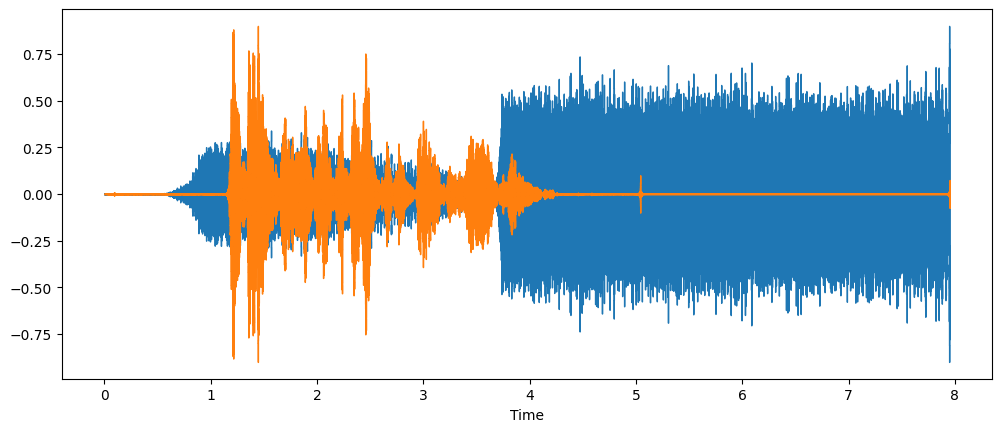

In [223]:
plt.figure().set_figwidth(12)
librosa.display.waveshow(y, sr=16000)
librosa.display.waveshow(y_target, sr=16000)

In [224]:
Audio(y, rate=16000)

In [29]:
import soundfile as sf
sf.write('output6.wav', y, 16000)  # Транспонируем для soundfile

In [167]:
torch.save(model.state_dict(), 'tts_model_words1.pth')  # Только веса
# ИЛИ
torch.save(model, 'tts_model_full_word1.pt')  # Веса + архитектура

In [ ]:
# Для state_dict
model = TTSTransformer(vocab_size, d_model=256, n_mels=80)
model.load_state_dict(torch.load('tts_model.pth'))
model.eval()

# Для полной модели
model = torch.load('tts_model_full.pt')
model.eval()

In [150]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cosine_similarity(y.reshape(-1, 1), df['array'][0].reshape(-1, 1))